# Notebook 02a — Préparation des data

**Objectif** : Fusionner les 4 années BAAC (2021-2024), nettoyer les data et produire un dataset unique prêt pour le feature engineering.

**Input** : Fichiers CSV bruts BAAC par année (2021-2024)
**Output** : `dataset_complet_raw.csv` (208 616 lignes)
**Notebook suivant** : `03a_features_intelligentes.ipynb`

---

## 1. Configuration et imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "png"

pd.set_option('display.max_columns', None)
DATA_DIR = Path("../../data")

# mapping des fichiers par année (noms différents selon les années)
FILE_MAPPINGS = {
    2021: {
        'caract': 'carcteristiques-2021.csv',
        'lieux': 'lieux-2021.csv',
        'usagers': 'usagers-2021.csv',
        'vehicules': 'vehicules-2021.csv'
    },
    2022: {
        'caract': 'carcteristiques-2022.csv',
        'lieux': 'lieux-2022.csv',
        'usagers': 'usagers-2022.csv',
        'vehicules': 'vehicules-2022.csv'
    },
    2023: {
        'caract': 'caract-2023.csv',
        'lieux': 'lieux-2023.csv',
        'usagers': 'usagers-2023.csv',
        'vehicules': 'vehicules-2023.csv'
    },
    2024: {
        'caract': 'caract-2024.csv',
        'lieux': 'lieux-2024.csv',
        'usagers': 'usagers-2024.csv',
        'vehicules': 'vehicules-2024.csv'
    }
}

ANNEES = [2021, 2022, 2023, 2024]

print("Configuration chargée")
print(f"Années à traiter : {ANNEES}")

Configuration chargée
Années à traiter : [2021, 2022, 2023, 2024]


---

## 2. Chargement et fusion des data multi-années

### Points d'attention

- 2022 : La clé primaire s'appelle Accident_Id au lieu de Num_Acc → renommage nécessaire
- 2021-2022 : Nom de fichier avec typo (carcteristiques au lieu de caracteristiques)

In [2]:
# charge et fusionne une table pour plusieurs années
def charger_table(table_name, annees):
    dfs = []
    
    for annee in annees:
        filepath = DATA_DIR / str(annee) / FILE_MAPPINGS[annee][table_name]
        df = pd.read_csv(filepath, sep=';', low_memory=False)
        
        # renommer Accident_Id → Num_Acc pour 2022
        if 'Accident_Id' in df.columns:
            df = df.rename(columns={'Accident_Id': 'Num_Acc'})
        
        df['annee'] = annee
        dfs.append(df)
        print(f"  {annee} : {len(df)} lignes")
    
    result = pd.concat(dfs, ignore_index=True)
    print(f"  TOTAL : {len(result)} lignes")
    
    return result

# Charger les 4 tables
print("\nCARACTERISTIQUES")
caract = charger_table('caract', ANNEES)

print("\nLIEUX")
lieux = charger_table('lieux', ANNEES)

print("\nUSAGERS")
usagers = charger_table('usagers', ANNEES)

print("\nVEHICULES")
vehicules = charger_table('vehicules', ANNEES)


CARACTERISTIQUES
  2021 : 56518 lignes
  2022 : 55302 lignes
  2023 : 54822 lignes
  2024 : 54402 lignes
  TOTAL : 221044 lignes

LIEUX
  2021 : 56518 lignes
  2022 : 55302 lignes
  2023 : 70860 lignes
  2024 : 70248 lignes
  TOTAL : 252928 lignes

USAGERS
  2021 : 129248 lignes
  2022 : 126662 lignes
  2023 : 125789 lignes
  2024 : 125187 lignes
  TOTAL : 506886 lignes

VEHICULES
  2021 : 97315 lignes
  2022 : 94493 lignes
  2023 : 93585 lignes
  2024 : 92678 lignes
  TOTAL : 378071 lignes


---

## 3. Création des targets

Deux variables cibles au niveau accident :

| Target | Définition | Déséquilibre attendu |
|--------|------------|---------------------|
| mortel | Au moins 1 tué (grav=2) | ~6% (ratio 1:16, très déséquilibré) |
| grave | Au moins 1 tué ou hospitalisé (grav∈{2,3}) | ~36% (ratio 1:1.8, modéré) |

Utilisation finale (décidée dans 04a/05a) :
- UC1 (Secours) : target grave au niveau accident — l'intervention rapide peut sauver une personne hospitalisée
- UC2 (Épidémiologie) : target grave_usager au niveau usager — analyse des facteurs de risque individuels

Note : Les deux targets sont créées ici pour permettre les analyses comparatives en aval. Les 419 usagers avec grav=-1 (gravité non renseignée, cf. 01_exploration.ipynb) sont exclus du calcul.

In [3]:
# création des targets au niveau accident
print("Création des targets...")

# on exclut les usagers avec gravité non renseignée (grav=-1)
usagers_target = usagers[usagers['grav'] != -1].copy()
n_exclus = len(usagers) - len(usagers_target)
print(f"Usagers exclus (grav=-1) : {n_exclus} / {len(usagers)}")

# target mortel : au moins un tué
mortel = usagers_target.groupby('Num_Acc')['grav'].apply(lambda x: (x == 2).any()).astype(int)

# target grave : au moins un tué ou hospitalisé
grave = usagers_target.groupby('Num_Acc')['grav'].apply(lambda x: x.isin([2, 3]).any()).astype(int)

target_df = pd.DataFrame({
    'Num_Acc': mortel.index,
    'mortel': mortel.values,
    'grave': grave.values
})

print(f"\nMORTEL : {mortel.sum()} / {len(mortel)} ({mortel.mean()*100:.1f}%)")
print(f"GRAVE  : {grave.sum()} / {len(grave)} ({grave.mean()*100:.1f}%)")
print(f"Ratio GRAVE/MORTEL : {grave.mean()/mortel.mean():.1f}x plus de cas positifs")

Création des targets...
Usagers exclus (grav=-1) : 419 / 506886

MORTEL : 12798 / 221044 (5.8%)
GRAVE  : 78907 / 221044 (35.7%)
Ratio GRAVE/MORTEL : 6.2x plus de cas positifs


In [4]:
# vérifier la stabilité des targets par année
targets_par_annee = usagers_target.groupby('annee').apply(
    lambda x: pd.Series({
        'n_accidents': x['Num_Acc'].nunique(),
        'n_mortels': x.groupby('Num_Acc')['grav'].apply(lambda g: (g == 2).any()).sum(),
        'n_graves': x.groupby('Num_Acc')['grav'].apply(lambda g: g.isin([2, 3]).any()).sum()
    })
).reset_index()

targets_par_annee['taux_mortel'] = targets_par_annee['n_mortels'] / targets_par_annee['n_accidents'] * 100
targets_par_annee['taux_grave'] = targets_par_annee['n_graves'] / targets_par_annee['n_accidents'] * 100

print("Taux par année :")
print(targets_par_annee[['annee', 'n_accidents', 'taux_mortel', 'taux_grave']].to_string(index=False))

Taux par année :
 annee  n_accidents  taux_mortel  taux_grave
  2021        56518     5.364663   34.596058
  2022        55302     6.034140   36.004123
  2023        54822     5.842545   36.089526
  2024        54402     5.929929   36.134701


/var/folders/5q/1z0_7_dd4559pfbhnn6y1dj80000gp/T/ipykernel_61495/2106660752.py:2: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



###   Validation : Stabilité temporelle confirmée

Les taux sont remarquablement stables sur 4 ans :
- Mortel : 5.4% → 6.0% (écart max ~0.7 points)
- Grave : 34.6% → 36.1% (écart max ~1.5 points)

Implication : Pas de dérive temporelle → on peut fusionner les années sans risque de data drift.

---

## 4. Préparation table CARACTÉRISTIQUES

Extraction des features temporelles et conversion GPS.

In [5]:
df_caract = caract.copy()

# --- features temporelles ---

# on extrait les 2 premiers chiffres de l'heure
df_caract['heure'] = df_caract['hrmn'].astype(str).str.replace(':', '').str.zfill(4).str[:2]
df_caract['heure'] = pd.to_numeric(df_caract['heure'], errors='coerce').fillna(12).astype(int)

# date complète
df_caract['date'] = pd.to_datetime(
    df_caract[['an', 'mois', 'jour']].rename(columns={'an': 'year', 'mois': 'month', 'jour': 'day'}),
    errors='coerce'
)

# jour de la semaine (0=lundi, 6=dimanche)
df_caract['jour_semaine'] = df_caract['date'].dt.dayofweek

df_caract['mois'] = df_caract['date'].dt.month

# --- features dérivées ---

# weekend
df_caract['weekend'] = (df_caract['jour_semaine'] >= 5).astype(int)

# heure de pointe (7h-9h et 17h-19h)
df_caract['heure_pointe'] = df_caract['heure'].apply(
    lambda h: 1 if (7 <= h <= 9) or (17 <= h <= 19) else 0
)

# nuit (codes lum 3, 4, 5)
df_caract['nuit'] = df_caract['lum'].isin([3, 4, 5]).astype(int)

# --- conversion GPS ---
df_caract['lat'] = pd.to_numeric(
    df_caract['lat'].astype(str).str.replace(',', '.'), 
    errors='coerce'
)
df_caract['long'] = pd.to_numeric(
    df_caract['long'].astype(str).str.replace(',', '.'), 
    errors='coerce'
)

# colonnes à garder
cols_caract = ['Num_Acc', 'annee', 'mois', 'lum', 'dep', 'com', 'agg', 'int', 'atm', 'col',
               'lat', 'long', 'heure', 'jour_semaine', 'weekend', 'heure_pointe', 'nuit']
df_caract = df_caract[cols_caract]

print(f"CARACT préparé : {df_caract.shape}")
print("Features temporelles : mois, heure, jour_semaine")
print("Features dérivées : weekend, heure_pointe, nuit")
print("Features géo : dep, com, lat, long")

CARACT préparé : (221044, 17)
Features temporelles : mois, heure, jour_semaine
Features dérivées : weekend, heure_pointe, nuit
Features géo : dep, com, lat, long


> **Choix** : On utilise `dep` (département) plutôt que les coordata GPS (`lat`, `long`). La granularité département est suffisante pour capturer les différences régionales sans risquer l'overfitting sur des coordata exactes.

> **Choix** : On conserve la colonne `annee` pour pouvoir faire un split temporel plus tard (train sur 2021-2023, test sur 2024).

---

## 5. Préparation table LIEUX

### Gestion des lieux multiples

14.3% des accidents ont plusieurs entrées dans LIEUX, mais ce phénomène est exclusif à 2023-2024 (~29% de ces années, 0% en 2021-2022). Il s'agit d'un changement de format BAAC pour les accidents aux intersections (cf. 01_exploration.ipynb, section 4.2).

Stratégie : Garder le lieu avec la VMA la plus élevée (voie principale).

Colonnes exclues : lartpc (largeur terre-plein central) = 99.9% NaN → inutilisable (cf. 01_exploration.ipynb, section 7).

### Implémentation

Nettoyage VMA (codes -1 → NaN), dédoublonnage par VMA max, imputation des valeurs manquantes (vma, nbv, larrout par leur médiane). Plafonnement VMA à 130 km/h (valeurs aberrantes). Nettoyage nbv (codes -1 et #VALEURMULTI → NaN).

> **Choix** : Quand un même lieu (Num_Acc) a plusieurs entrées, on garde la VMA maximale. C'est la vitesse la plus représentative du danger réel sur le tronçon.

In [6]:
# nettoyer vma avant tri
lieux_clean = lieux.copy()
lieux_clean['vma'] = pd.to_numeric(lieux_clean['vma'], errors='coerce')
lieux_clean['vma'] = lieux_clean['vma'].replace(-1, np.nan)

# trier par VMA décroissante et garder le premier (VMA max)
lieux_clean = lieux_clean.sort_values('vma', ascending=False)
df_lieux = lieux_clean.drop_duplicates(subset='Num_Acc', keep='first').copy()

print(f"Dédoublonnage LIEUX : {len(lieux)} → {len(df_lieux)} (-{len(lieux)-len(df_lieux)})")

# imputer vma manquantes par la médiane, puis plafonner à 130 km/h
vma_median = df_lieux['vma'].median()
df_lieux['vma'] = df_lieux['vma'].fillna(vma_median)
df_lieux['vma'] = df_lieux['vma'].clip(upper=130)
print(f"VMA médiane (imputation) : {vma_median:.0f} km/h")
print("VMA plafonnée à 130 km/h (valeurs aberrantes corrigées)")

# nettoyer nbv (-1 et #VALEURMULTI → NaN, puis médiane)
df_lieux['nbv'] = pd.to_numeric(df_lieux['nbv'].replace('#VALEURMULTI', np.nan), errors='coerce')
df_lieux['nbv'] = df_lieux['nbv'].replace(-1, np.nan)
df_lieux['nbv'] = df_lieux['nbv'].fillna(df_lieux['nbv'].median())

# nettoyer larrout
df_lieux['larrout'] = pd.to_numeric(
    df_lieux['larrout'].astype(str).str.replace(',', '.'), 
    errors='coerce'
)
df_lieux['larrout'] = df_lieux['larrout'].fillna(df_lieux['larrout'].median())

# colonnes à garder (on exclut lartpc car 99.9% NaN)
cols_lieux = ['Num_Acc', 'catr', 'circ', 'nbv', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'vma', 'larrout']
df_lieux = df_lieux[cols_lieux]

print(f"\nLIEUX préparé : {df_lieux.shape}")

Dédoublonnage LIEUX : 252928 → 221044 (-31884)
VMA médiane (imputation) : 50 km/h
VMA plafonnée à 130 km/h (valeurs aberrantes corrigées)

LIEUX préparé : (221044, 12)


### Observation : Résultat du dédoublonnage

- 31,884 lignes supprimées (12.6% des lignes LIEUX)
- Correspond aux 14.3% d'accidents ayant plusieurs lieux (exclusivement 2023-2024, changement de format BAAC)
- La stratégie "garder VMA max" privilégie la voie principale à l'intersection

VMA médiane = 50 km/h : Cohérent avec une majorité d'accidents en zone urbaine/péri-urbaine.

---

## 6. Préparation table VÉHICULES (agrégation)

Agrégation au niveau accident : nombre de véhicules, types présents, obstacles.

In [7]:
# regroupement des types de véhicules
catv_groups = {
    'catv_velo': [1, 80],
    'catv_edp': [50, 60],
    'catv_cyclomoteur': [2, 30],
    'catv_moto': [31, 32, 33, 34],
    'catv_voiture': [7],
    'catv_utilitaire': [10],
    'catv_poids_lourd': [13, 14, 15, 16, 17],
    'catv_bus': [37, 38],
}

# agréger par accident
df_vehicules = vehicules.groupby('Num_Acc').agg(
    nb_vehicules=('id_vehicule', 'nunique'),
    catv_list=('catv', list),
    obs_max=('obs', 'max'),
    obsm_max=('obsm', 'max'),
    choc_mode=('choc', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else -1),
    manv_mode=('manv', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else -1),
).reset_index()

# colonnes binaires par type de véhicule
for col_name, codes in catv_groups.items():
    df_vehicules[col_name] = df_vehicules['catv_list'].apply(
        lambda x: int(any(v in codes for v in x))
    )

df_vehicules = df_vehicules.drop(columns=['catv_list'])

print(f"VEHICULES agrégé : {df_vehicules.shape}")
print(f"Colonnes binaires véhicules : {list(catv_groups.keys())}")

VEHICULES agrégé : (221044, 14)
Colonnes binaires véhicules : ['catv_velo', 'catv_edp', 'catv_cyclomoteur', 'catv_moto', 'catv_voiture', 'catv_utilitaire', 'catv_poids_lourd', 'catv_bus']


---

## 7. Préparation table USAGERS (agrégation)

Agrégation au niveau accident : nombre d'usagers, âges, sexes.

Attention : Ne pas utiliser grav en feature (c'est la target).

In [8]:
# calculer l'âge au moment de l'accident (pas avec l'année courante sinon biais)
usagers_clean = usagers.copy()
usagers_clean['age'] = usagers_clean['annee'] - usagers_clean['an_nais'].replace(-1, np.nan)

# agréger par accident (sans utiliser grav !)
df_usagers = usagers_clean.groupby('Num_Acc').agg(
    nb_usagers=('id_usager', 'count'),
    nb_conducteurs=('catu', lambda x: (x == 1).sum()),
    nb_passagers=('catu', lambda x: (x == 2).sum()),
    nb_pietons=('catu', lambda x: (x == 3).sum()),
    nb_hommes=('sexe', lambda x: (x == 1).sum()),
    nb_femmes=('sexe', lambda x: (x == 2).sum()),
    age_moyen=('age', 'mean'),
    age_min=('age', 'min'),
    age_max=('age', 'max'),
    trajet_mode=('trajet', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else -1),
    secu_mode=('secu1', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else -1),
).reset_index()

# imputer les âges manquants
for col in ['age_moyen', 'age_min', 'age_max']:
    df_usagers[col] = df_usagers[col].fillna(df_usagers[col].median())

print(f"USAGERS agrégé : {df_usagers.shape}")

USAGERS agrégé : (221044, 12)


---

## 8. Fusion de toutes les tables

In [9]:
# fusion progressive
print("Fusion des tables...")

df = df_caract.merge(df_lieux, on='Num_Acc', how='inner')
print(f"  CARACT + LIEUX : {len(df)}")

df = df.merge(df_vehicules, on='Num_Acc', how='inner')
print(f"  + VEHICULES    : {len(df)}")

df = df.merge(df_usagers, on='Num_Acc', how='inner')
print(f"  + USAGERS      : {len(df)}")

df = df.merge(target_df, on='Num_Acc', how='inner')
print(f"  + TARGETS      : {len(df)}")

Fusion des tables...
  CARACT + LIEUX : 221044
  + VEHICULES    : 221044
  + USAGERS      : 221044
  + TARGETS      : 221044


---

## 9. Filtrage France métropolitaine

Le filtre GPS exclut les accidents hors France métropolitaine (DOM-TOM, GPS manquants/invalides). On vérifie ensuite que le filtrage n'introduit pas de biais dans les taux.

In [10]:
# filtre GPS France métropolitaine
n_avant = len(df)

metropole = (
    (df['lat'] >= 41) & (df['lat'] <= 51.5) &
    (df['long'] >= -5.5) & (df['long'] <= 10)
)

df = df[metropole].copy()
n_apres = len(df)

print(f"Filtre France métropolitaine : {n_avant} → {n_apres}")
print(f"Exclus : {n_avant - n_apres} ({(n_avant - n_apres)/n_avant*100:.1f}%)")

Filtre France métropolitaine : 221044 → 208616
Exclus : 12428 (5.6%)


###   Validation post-filtrage

Après exclusion des accidents hors métropole (12,428 accidents, 5.6%) :
- Les taux de mortalité restent stables par année (5.2% - 5.9%)
- Distribution équilibrée : ~51-53k accidents par année
- Pas de biais introduit par le filtrage géographique

In [11]:
# répartition par année après filtre
print("Répartition par année après filtre :")
repartition = df.groupby('annee').agg(
    n_accidents=('Num_Acc', 'count'),
    taux_mortel=('mortel', 'mean'),
    taux_grave=('grave', 'mean')
).reset_index()

repartition['taux_mortel'] = (repartition['taux_mortel'] * 100).round(1)
repartition['taux_grave'] = (repartition['taux_grave'] * 100).round(1)

print(repartition.to_string(index=False))

Répartition par année après filtre :
 annee  n_accidents  taux_mortel  taux_grave
  2021        53540          5.2        34.1
  2022        52380          5.9        35.5
  2023        51641          5.8        35.9
  2024        51055          5.9        35.9


---

## 10. Vérification des features créées

Récapitulatif des colonnes du dataset final.

In [12]:
# récap des colonnes par catégorie
cat_cols = ['lum', 'dep', 'com', 'agg', 'int', 'atm', 'col', 'catr', 'circ', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ',
            'obs_max', 'obsm_max', 'choc_mode', 'manv_mode', 'trajet_mode', 'secu_mode']

num_cols = ['lat', 'long', 'heure', 'jour_semaine', 'mois', 'vma', 'nbv', 'larrout', 
            'nb_vehicules', 'nb_usagers', 'nb_conducteurs', 'nb_passagers', 'nb_pietons',
            'nb_hommes', 'nb_femmes', 'age_moyen', 'age_min', 'age_max']

bin_cols = ['weekend', 'heure_pointe', 'nuit',
            'catv_velo', 'catv_edp', 'catv_cyclomoteur', 'catv_moto', 
            'catv_voiture', 'catv_utilitaire', 'catv_poids_lourd', 'catv_bus']

meta_cols = ['Num_Acc', 'annee']
target_cols = ['mortel', 'grave']

print("RECAPITULATIF DES FEATURES")
print("---")
print(f"  Catégorielles ({len(cat_cols)}) : {cat_cols}")
print(f"  Numériques ({len(num_cols)}) : {num_cols}")
print(f"  Binaires ({len(bin_cols)}) : {bin_cols}")
print(f"  Métadata ({len(meta_cols)}) : {meta_cols}")
print(f"  Targets ({len(target_cols)}) : {target_cols}")
print(f"  Total : {len(cat_cols) + len(num_cols) + len(bin_cols) + len(meta_cols) + len(target_cols)} colonnes")

RECAPITULATIF DES FEATURES
---
  Catégorielles (21) : ['lum', 'dep', 'com', 'agg', 'int', 'atm', 'col', 'catr', 'circ', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'obs_max', 'obsm_max', 'choc_mode', 'manv_mode', 'trajet_mode', 'secu_mode']
  Numériques (18) : ['lat', 'long', 'heure', 'jour_semaine', 'mois', 'vma', 'nbv', 'larrout', 'nb_vehicules', 'nb_usagers', 'nb_conducteurs', 'nb_passagers', 'nb_pietons', 'nb_hommes', 'nb_femmes', 'age_moyen', 'age_min', 'age_max']
  Binaires (11) : ['weekend', 'heure_pointe', 'nuit', 'catv_velo', 'catv_edp', 'catv_cyclomoteur', 'catv_moto', 'catv_voiture', 'catv_utilitaire', 'catv_poids_lourd', 'catv_bus']
  Métadonnées (2) : ['Num_Acc', 'annee']
  Targets (2) : ['mortel', 'grave']
  Total : 54 colonnes


### Validation : Structure du dataset

54 colonnes créées avec succès :
- 21 catégorielles (codes BAAC originaux)
- 18 numériques (dont mois ajouté)
- 11 binaires (dont weekend, heure_pointe, nuit ajoutés)
- 2 métadata (Num_Acc, annee)
- 2 targets (mortel, grave)

Features UC1-safe (disponibles à l'appel) :
- Temporelles : heure, jour_semaine, mois, weekend, heure_pointe, nuit
- Localisation : dep, com, agg, catr, vma
- Contexte : lum, atm, col (si décrit par l'appelant)

Features UC1-unsafe (à exclure pour temps réel) :
- Post-accident : obs_max, obsm_max, choc_mode, manv_mode
- Constatées sur place : secu_mode, trajet_mode, nb_pietons exact

Colonnes exclues en amont (cf. 01_exploration.ipynb) :
- lartpc (99.9% NaN) et occutc (99.1% NaN)

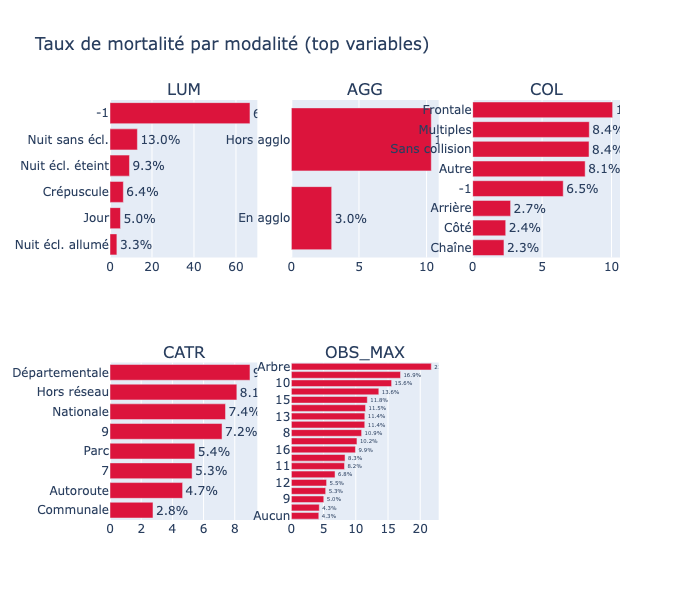

In [13]:
# analyser les variables les plus prédictives (top 5)
top_cat_cols = ['lum', 'agg', 'col', 'catr', 'obs_max']

labels = {
    'lum': {1: 'Jour', 2: 'Crépuscule', 3: 'Nuit sans écl.', 4: 'Nuit écl. éteint', 5: 'Nuit écl. allumé'},
    'agg': {1: 'Hors agglo', 2: 'En agglo'},
    'col': {1: 'Frontale', 2: 'Arrière', 3: 'Côté', 4: 'Chaîne', 5: 'Multiples', 6: 'Autre', 7: 'Sans collision'},
    'catr': {1: 'Autoroute', 2: 'Nationale', 3: 'Départementale', 4: 'Communale', 5: 'Hors réseau', 6: 'Parc'},
    'obs_max': {0: 'Aucun', 1: 'Véhicule', 2: 'Arbre', 3: 'Glissière', 4: 'Poteau', 5: 'Mobilier urbain', 6: 'Mur'}
}

fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=[f'{col.upper()}' for col in top_cat_cols] + [''],
    specs=[[{"type": "bar"}, {"type": "bar"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "bar"}, {"type": "bar"}]]
)

positions = [(1,1), (1,2), (1,3), (2,1), (2,2)]

for idx, col in enumerate(top_cat_cols):
    row, col_pos = positions[idx]
    
    analyse = df.groupby(col).agg(
        n=('mortel', 'count'),
        taux_mortel=('mortel', 'mean'),
        taux_grave=('grave', 'mean')
    ).reset_index()
    
    analyse['taux_mortel'] = analyse['taux_mortel'] * 100
    analyse['taux_grave'] = analyse['taux_grave'] * 100
    
    if col in labels:
        analyse['label'] = analyse[col].map(labels[col]).fillna(analyse[col].astype(str))
    else:
        analyse['label'] = analyse[col].astype(str)
    
    analyse = analyse.sort_values('taux_mortel', ascending=True)
    
    fig.add_trace(
        go.Bar(
            y=analyse['label'],
            x=analyse['taux_mortel'],
            orientation='h',
            name=col,
            marker_color='crimson',
            text=analyse['taux_mortel'].apply(lambda x: f'{x:.1f}%'),
            textposition='outside',
            showlegend=False
        ),
        row=row, col=col_pos
    )

fig.update_layout(
    title_text='Taux de mortalité par modalité (top variables)',
    height=600,
    showlegend=False
)

fig.show()

---

## 11. Sauvegarde du dataset

In [14]:
df_final = df.copy()

# sauvegarde du dataset
df_final.to_csv(DATA_DIR / 'dataset_complet_raw.csv', index=False)
print(f"Sauvegarde : dataset_complet_raw.csv ({df_final.shape[0]} lignes x {df_final.shape[1]} colonnes)")

print("---")
print("RESUME DU DATASET")
print(f"  Accidents : {len(df_final)}")
print(f"  Colonnes  : {df_final.shape[1]}")
print(f"  Taux mortel : {df_final['mortel'].mean()*100:.1f}%")
print(f"  Taux grave  : {df_final['grave'].mean()*100:.1f}%")

Sauvegarde : dataset_complet_raw.csv (208616 lignes x 54 colonnes)
---
RESUME DU DATASET
  Accidents : 208616
  Colonnes  : 54
  Taux mortel : 5.7%
  Taux grave  : 35.4%


---

## 12. Résumé et insights

---

## Points d'attention pour la modélisation

### Risques de data leakage pour UC1 (temps réel)

Certaines features ne sont pas disponibles au moment de l'appel des secours :

| Feature | Problème | Disponibilité |
|---------|----------|---------------|
| obs_max, obsm_max | Obstacles constatés APRÈS l'accident | Non dispo UC1 |
| choc_mode, manv_mode | Points de choc = analyse post-accident | Non dispo UC1 |
| secu_mode | Équipements = constat sur place | Non dispo UC1 |
| trajet_mode | Motif = interrogatoire | Non dispo UC1 |
| nb_usagers, nb_pietons | Comptage complet = sur place | Estimable |
| age_* | Âges précis = sur place | Estimable |

--> UC1 utilisera uniquement les features connues au moment de l'appel.

### Multicolinéarité probable (à vérifier en 03a)

- nb_vehicules <-> nb_conducteurs <-> nb_usagers
- age_min <-> age_moyen <-> age_max
- nuit <-> lum (dérivée de)

---
## Récapitulatif

| Décision | Choix | Justification |
|----------|-------|---------------|
| Granularité géo | `dep` (département) | Évite l'overfitting des coordata GPS |
| Période | 2021-2024 | 4 ans pour la robustesse + split temporel |
| Dédoublonnage lieux | VMA max | Représente le danger réel du tronçon |
| Colonne `annee` | Conservée | Nécessaire pour le split temporel train/test |

**Prochaine étape** → `03a_features_intelligentes.ipynb` : création de features dérivées et interactions.